## Exercise: Create a Knowledge Base Agent


Welcome to your Knowledge Base Agent Challenge!  

In this exercise, you'll create an agent that can answer user questions by consulting a collection of documents. Instead of relying solely on the model’s internal knowledge, the agent will ground its responses in an external source of truth.

Scenario  
You’re building a support assistant for a company that maintains a large set of internal documentation, such as FAQs, policy guides, and how-to manuals. The assistant should be able to:
  
Search through the documentation
Retrieve the most relevant sections
Provide helpful answers grounded in the retrieved information
This approach, aka Retrieval-Augmented Generation (RAG) — is a powerful technique for building agents that are accurate, verifiable, and up-to-date.
  
Challenge  
Your task is to create a LangGraph Workflow that includes:  

A document loading and vectorization process for a knowledge base.
An Agent Node capable of:
Retrieving relevant knowledge.
Augmenting responses with contextual documents.
Generating accurate answers.
Conditional routing to control query resolution.
Optimization techniques such as text chunking and embedding search.

## 0. Import the necessary libs


In [1]:
from typing import List
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from IPython.display import Image, display

## 1. Instantiate Chat Model with your API Key
To be able to connect with OpenAI, you need to instantiate an ChatOpenAI client passing your OpenAI key.

You can pass the api_key argument directly.

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key="voc-",
)

In [2]:
# TODO - Instantiate your chat model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
 #   api_key = "YOUR_API_KEY_HERE",    # It's already in my venv
)

In [3]:
# TODO - Instantiate your embeddings model
embeddings_fn = OpenAIEmbeddings(
    model="text-embedding-3-large"
  #  api_key = "YOUR_API_KEY_HERE",    # Does this still work though?
)

## 2. Load and Process Documents

In [4]:
# TODO create your Chroma vector store with a collection name 
# and the embedding function
vector_store = Chroma(
    collection_name="udacity",
    embedding_function=embeddings_fn
)

In [7]:
file_path = "Arcadia-30_Grayscale.pdf"

In [8]:
loader = PyPDFLoader(file_path)

In [10]:
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [11]:
# TODO - Create a text splitter with chunk_size and chunk_overlap 
# values of 1000 and 200, respectively
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

In [12]:
all_splits = text_splitter.split_documents(pages)

In [13]:
_ = vector_store.add_documents(documents=all_splits)

## 3. Define State Schema

We define a State Schema for managing:

User query
Retrieved documents
Generated answer

In [14]:
# TODO - Create your state schema named State inheriting from MessagesState
# with question(str), documents(List) and answer(str) attributes
class State(MessagesState):
    question: str
    documents: List[Document]
    answer: str
    

## 4. RAG Nodes
The agent should:
  
fetch relevant document chunks based on the user query
combine the retrieved documents and use them as context
invoke the LLM to generate a response

In [15]:
def retrieve(state: State):
    question = state["question"]

    # TODO - Use the vector store to retrieve similar documents to the question
    # Use the similarity_search() method
    retrieved_docs = vector_store.similarity_search(question)

    return {"documents": retrieved_docs}

In [16]:
def augment(state: State):
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)

    # TODO - Create a RAG ChatPromptTemplate with question and context variables
    template = ChatPromptTemplate([
        ("system", "You are an assistant for question-answering tasks."),
        ("human", "Use the following pieces of retrieved content to answer the question."
                 "If you don't know the answr, just say you don't know."
                 "Use three sentences maximum and keep the answer concise."
                 "\n# Question: \n-> {question} "
                 "\n# Context: \n-> {context} "
         "\n# Answer: "),
    ])

    messages = template.invoke(
        {"context": docs_content, "question": question}
    ).to_messages()

    return {"messages": messages}

In [17]:
def generate(state: State):
    # TODO - Invoke the LLM passing the messages from state
    ai_message = llm.invoke(state["messages"])
    return {"answer": ai_message.content, "messages": ai_message}

## 5. Build the LangGraph Workflow

In [18]:
workflow = StateGraph(State)
# TODO - add all the nodes and edges
workflow.add_node("retrieve", retrieve)
workflow.add_node("augment", augment)
workflow.add_node("generate", generate)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "augment")
workflow.add_edge("augment", "generate")
workflow.add_edge("generate", END)


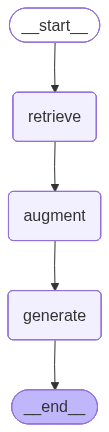

In [19]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

## 6. Invoke the Agent with a Query
Run and Print the retrieved documents to check search accuracy.

In [20]:
output = graph.invoke(
    {"question": "Who is Kamira Suhan?"}
)

In [21]:
output["answer"]

'Kamira Suhan is a tiefling diviner known for her fortune-telling abilities, using a combination of dream interpretation and a special deck of cards. Once seen as a bad omen, she now works to show her divinations can be used for good. Kamira is a member of the Thread, a group that relies on her premonitions to guide their actions.'

In [22]:
for message in output["messages"]:
    message.pretty_print()

================================ System Message ================================

You are an assistant for question-answering tasks.
================================ Human Message =================================

Use the following pieces of retrieved content to answer the question.If you don't know the answr, just say you don't know.Use three sentences maximum and keep the answer concise.
# Question: 
-> Who is Kamira Suhan? 
# Context: 
-> might hear of her.
 When characters first meet or encounter Kamira, read 
or paraphrase the following:
Y ou hear the rustling of a deck of cards being shuffled in 
fast-moving hands just as a tiefling appears before you, 
grinning broadly. She is in her middle years, with dark-red 
skin, black eyes, and a set of black horns nearly as long 
as her broad shoulders are wide, and she has an air of 
confidence about her. “Want to know your future?” she 
asks with a wink and a nod toward the nearest table. “I 
promise you’ll probably enjoy it. ”

often 

## 7. Experiment
Now that you understood how it works, experiment with new things.
  
Change the embedding model
Change the parameters of RecursiveCharacterTextSplitter(chunk_size and chunk_overlap)
Use your own document
Add More File Types

## Summary: Knowledge Base Agent with RAG  
Overview  
This exercise demonstrates how to create a knowledge base (KB) agent using Retrieval-Augmented Generation (RAG) techniques in LangGraph. The agent uses vector embeddings to retrieve relevant context from a document and answers user questions by augmenting the prompt with that context.
  
Key Steps Covered  
1. Environment Setup  
OpenAI's chat model (ChatOpenAI) and embedding model (OpenAIEmbeddings) are initialized.
A vector store is created using Chroma, with a custom collection name and the embedding function.
vectorstore = Chroma(collection_name="udacity", embedding_function=embedding)  
2. Document Preparation  
A PDF file (provided in the environment) is loaded using PyPDFLoader (async).
The text is split using a RecursiveCharacterTextSplitter with:
chunk_size=1000
chunk_overlap=200
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
documents = text_splitter.split_documents(pages)
vectorstore.add_documents(documents)  
3. Session State Definition  
A custom state class is defined, extending MessageGraphState, and includes:
question: user input string
documents: list of retrieved documents
answer: model-generated answer
class State(MessageGraphState):
  question: str
  documents: List[Document]
  answer: str  
4. RAG Workflow Nodes  
a. Retrieve Node
Performs a similarity search using the vector store.
Retrieves documents related to the input question and stores them in state.
def retrieve(state):
  docs = vectorstore.similarity_search(state["question"])
  return {"documents": docs}
b. Augment Node
Uses a ChatPromptTemplate with placeholders for question and context.
Constructs a system message with relevant document excerpts and user input.
prompt = ChatPromptTemplate.from_messages([
  ("system", "Answer using the following context:\n\n{context}"),
  ("human", "{question}")
])
c. Generate Node
Calls the LLM with the constructed prompt to produce an answer.
def generate(state):
  return {"answer": llm.invoke(state["messages"]).content}  
5. Workflow Construction  
A LangGraph StateGraph is created with four nodes:
retrieve, augment, generate, end
Sequential edges connect the nodes to form the RAG pipeline:
start → retrieve → augment → generate → end
workflow = StateGraph(State)
workflow.add_node("retrieve", retrieve)
workflow.add_node("augment", augment)
workflow.add_node("generate", generate)
workflow.set_entry_point("retrieve")
workflow.set_finish_point("generate")  
6. Execution and Testing  
The workflow is compiled and visualized.

Sample query: "What are open source models?"

Output:

Relevant context is retrieved from Section 3 of the document.
LLM response is correctly augmented: "Open source models are language models developed and shared by the community..."
The state history confirms that:

The user's question was processed,
The appropriate context was retrieved,
A complete answer was generated using RAG.  
7. Encouraged Exploration  
Learners are encouraged to:
Ask new questions of the document.
Adjust chunk sizes and overlaps.
Swap out the embedding model or vector store.